In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<H2 align="center"> Pre-Processing </H2>

In [5]:
data = pd.read_csv('../data/model_data/spatial_df/Lassa_spatialdataset_201219separateyears_labconfirmed.csv')
data.dropna(inplace=True)

In [7]:
# Creating LGA names set and then assigning them their indices as values
lga_names = set(data['LGA'])
lga_replace_dict = {value: i for i, value in enumerate(lga_names)}

# Creating Year names set and then assigning them their indices as values
year_names = set(data['Year'])
year_replace_dict = {value: i for i, value in enumerate(year_names)}

# Creating Admin names set and then assigning them their indices as values
administration_names = set(data['admin1Name'])
administration_replace_dict = {value: i for i, value in enumerate(administration_names)}

# Creating Source names set and then assigning them their indices as values
source_names = set(data['Source'])
source_replace_dict = {value: i for i, value in enumerate(source_names)}

In [8]:
# Replaces string values for integer values in dataset
data = data.replace({'LGA':lga_replace_dict, 
                     'Year': year_replace_dict,
                     'admin1Name': administration_replace_dict,
                     'Source': source_replace_dict})

In [9]:
# Features that were already normalized in the dataset
ignore_norm_cols_array = ["AgriProp_ESA", "UrbanProp_ESA", "ForestProp_ESA", "TempMonthlyCoefv_201118_NOAA",
                     "TotalPop2015_PropUrban", "ImprovedHousingPrev_PopWeighted", "Cropland_prop_ESA2015",
                     "Agri_prop_ESA2015", "Urb_prop_ESA2015", "Forest_prop_ESA2015", "PovertyProp_Mean",
                     "PovertyProp_PopWeighted"]

# Normalize the data
for heading in data.columns:  
  if heading not in ignore_norm_cols_array:
    data[heading] = ( data[heading] - ( min(data[heading]) ) ) / ( max(data[heading]) - min(data[heading]) )

# Remove these columns
data = data.loc[:, ~data.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Source', 'x', 'y', 'Reports_All'])]

In [50]:
# Set target variable as only the confirmed cases of LF; 'Any_Confirmed_Cases' is a binary class
x = data.iloc[:, data.columns != 'Any_Confirmed_Cases']
y = data.iloc[:, data.columns == 'Any_Confirmed_Cases']

# Retype from float to int
y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

<H2 align="center"> Random Forest Classifier Model</H2>

In [53]:
clf = RandomForestClassifier(criterion='entropy',
                            max_depth=8,
                            min_samples_split=10,
                            random_state=5,
                            bootstrap=True)
clf.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=10,
                       random_state=5)

In [54]:
y_pred = clf.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
# C_{0,0} = TN = 1470
# C_{1,0} = FN = 61
# C_{1,1} = TP = 15
# C_{0,1} = FP = 2
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1469,    3],
       [  65,   11]])

In [56]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.24444444444444444

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9560723514211886

In [58]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, x_train, y_train, cv=10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

array([0.9483871 , 0.9483871 , 0.95053763, 0.94623656, 0.95258621,
       0.94827586, 0.95258621, 0.94396552, 0.95258621, 0.95474138])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1534
           1       0.14      0.79      0.24        14

    accuracy                           0.96      1548
   macro avg       0.57      0.87      0.61      1548
weighted avg       0.99      0.96      0.97      1548



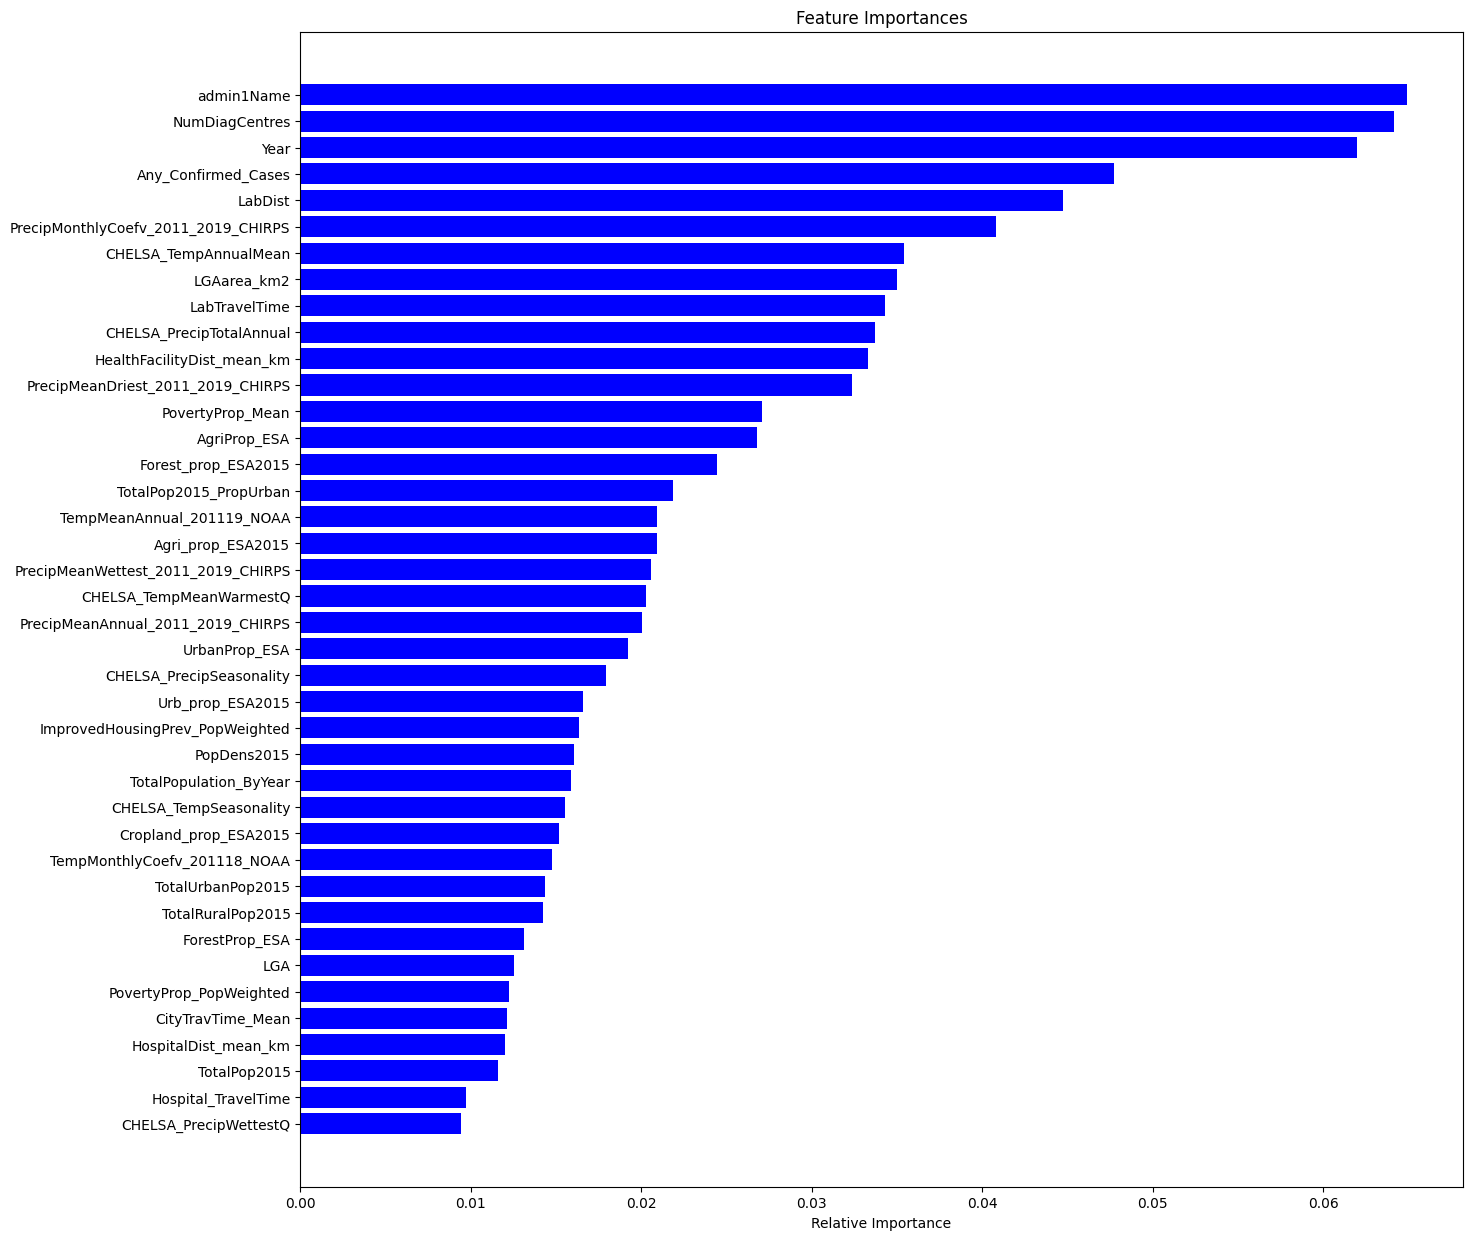

In [60]:
features = data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(15, 15))

ax.set_title("Feature Importances")
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
plt.show()

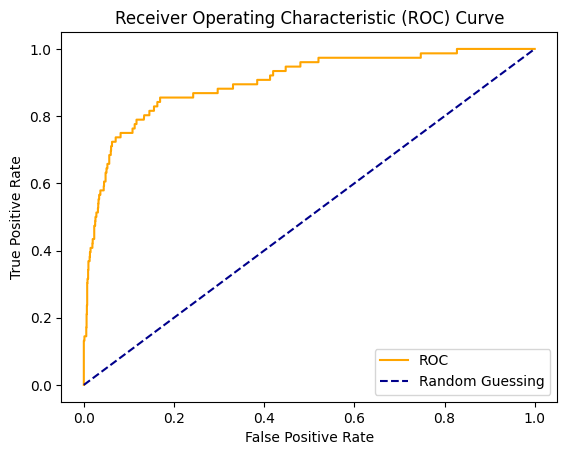

In [61]:
from sklearn.metrics import roc_curve
yer = clf.predict_proba(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

<H2 align="center"> SHAP ANALYSIS </H2>

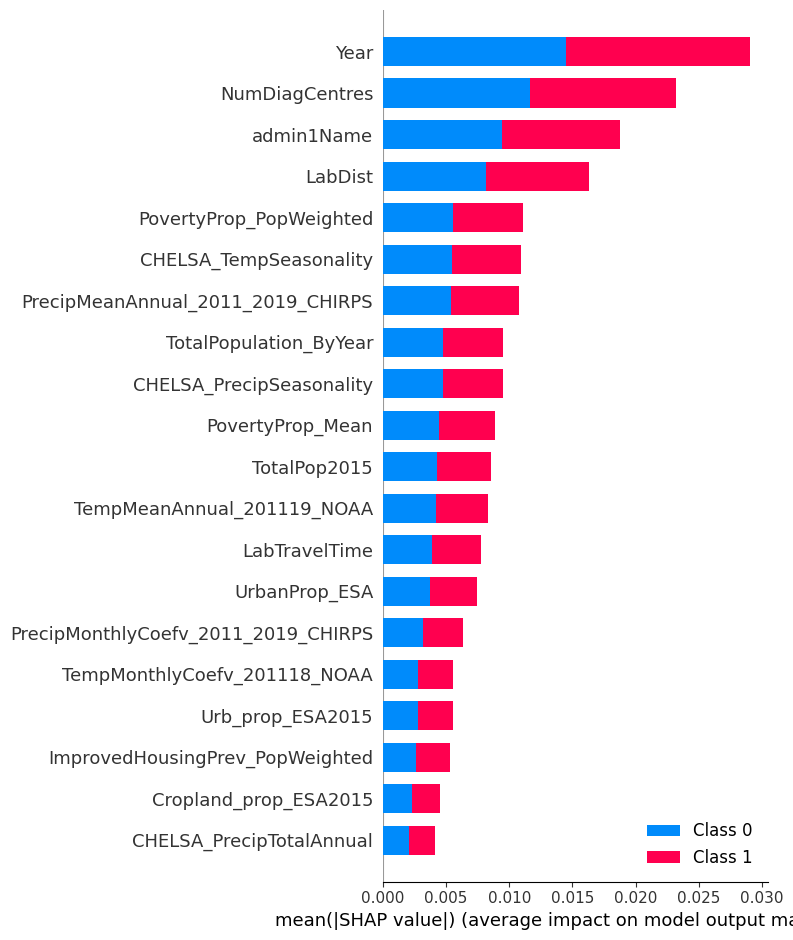

In [62]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type='bar')

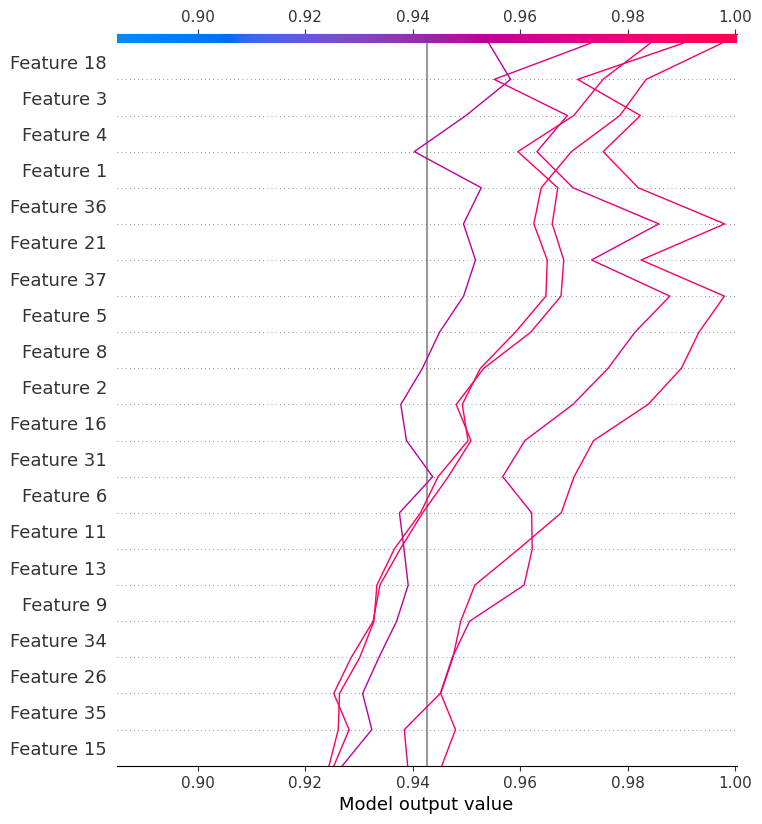

In [21]:
base = explainer.expected_value
base
shap.decision_plot(base_value=base[0], shap_values=shap_values[0][0:5])

In [63]:
explainer = shap.Explainer(clf, x_test)
shap_values = explainer(x_test)
shap.plots.beeswarm(shap_values[0], check_additivity=False)

 97%|=================== | 3015/3096 [00:14<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.869092, while the model output was 0.859092. If this difference is acceptable you can set check_additivity=False to disable this check.